# PUNTO 3

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm

In [2]:
class Particle:
    
    def __init__(self, r0, v0, a0, t, m=1, radius=2., Id=0):
        
        self.dt = t[1] - t[0]
        
        
        # Atributos instantaneos
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
        
        self.p = self.m*self.v
        
        self.f = self.m*self.a
        
        # Historial
        
        self.R = np.zeros((len(t),len(r0)))
        self.V = np.zeros_like(self.R)
        self.A = np.zeros_like(self.R)
        
        self.F = np.zeros_like(self.R)
        
        self.P = np.zeros_like(self.R)
    
        # Fisica
        self.K = 20.
        
        self.VEk = np.zeros(len(t))
        
        self.potential_energy = 0  # Inicializar la energía potencial
        
    def Evolution(self,i):
        
        
        self.SetPosition(i)
        self.SetVelocity(i)
        
        self.a = self.f/self.m
        
        # Euler
  #      self.r += self.dt*self.v
  #      self.v += self.dt*self.a
        
        # Euler-Cromer
        self.v += self.dt*self.a
        self.r += self.dt*self.v
        
        
    def CalculateForce(self,p):
        
        d = np.linalg.norm(self.r - p.r)
    
        compresion = self.radius + p.radius - d

        if compresion >= 0:

            Fn = self.K * compresion**3

            self.n = (self.r - p.r) / d
            self.f = np.add(self.f, Fn * self.n)

            # Calcular la energía potencial debido a la compresión
            U = 0.5 * self.K * compresion**2  # Energía potencial elástica

            self.potential_energy += U

     
    def ResetForce(self):
        self.f[:] = 0.
        self.a[:] = 0.
        self.potential_energy = 0
    
    # Setter
    def SetPosition(self,i):
        self.R[i] = self.r
    
    def SetVelocity(self,i):
        self.V[i] = self.v
        self.P[i] = self.m*self.v
        self.VEk[i] = 0.5*self.m*np.dot(self.v,self.v)
    
    # Getter
    def GetPosition(self,scale=1):
        return self.R[::scale]
    
    def GetVelocity(self,scale=1):
        return self.V[::scale]
 
    def GetMomentum(self,scale=1):
        return self.P[::scale]
    
    def GetKineticEnergy(self,scale=1):
        return self.VEk[::scale] 
    
    def CheckLimits(self):
        max_x = -5. # Límite máximo en el eje x
        min_x = -20.  # Límite mínimo en el eje x
        max_y = 20.  # Límite máximo en el eje y
        min_y = -20. # Límite mínimo en el eje y que también actúa como el "suelo" para los rebotes

        e = 0.9  # Coeficiente de restitución para conservar el 90% de la energía cinética
        # Revisa los límites en x
        for i in range(2):
            if self.r[i] + self.radius > max_x or self.r[i] - self.radius <= min_x:
                self.v[i] = -e * self.v[i]

            # Revisa los límites en y para el rebote
            elif self.r[i] + self.radius >= max_y or self.r[i] - self.radius <= min_y:
                self.v[i] = -e * self.v[i]  # Aplica el coeficiente de restitución solo en la componente y

In [3]:
def GetParticles(N, t):
    # Definir las condiciones iniciales de la única partícula
    r0 = np.array([-15, -10.])  # Posición inicial
    v0 = np.array([2., -9.8])    # Velocidad inicial
    a0 = np.array([0., 0.])    # Aceleración inicial

    # Crear una única partícula con los parámetros dados
    p0 = Particle(r0, v0, a0, t, m=1, radius=2, Id=0)

    # Devolver una lista que contiene solo esta partícula
    Particles = [p0]

    return Particles

In [4]:
dt = 0.001
tmax = 30
t = np.arange(0,tmax,dt)
Particles = GetParticles(1,t)

In [5]:
def RunSimulation(t,Particles):
    
    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):
        
        for i in range(len(Particles)):
            for j in range(len(Particles)):
                if i!=j:
                    Particles[i].CalculateForce(Particles[j])
        
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            Particles[i].CheckLimits()
            # Aca debes agregar la interaccion con la pared
            
            
    return Particles

In [6]:
Particles = RunSimulation(t,Particles)

Running simulation: 100%|██████████| 30000/30000 [00:00<00:00, 73257.88 Steps/s]


In [7]:
# Bajamos dimensión de la simulacion
scale = 100
t1 = t[::scale]

<IPython.core.display.Javascript object>


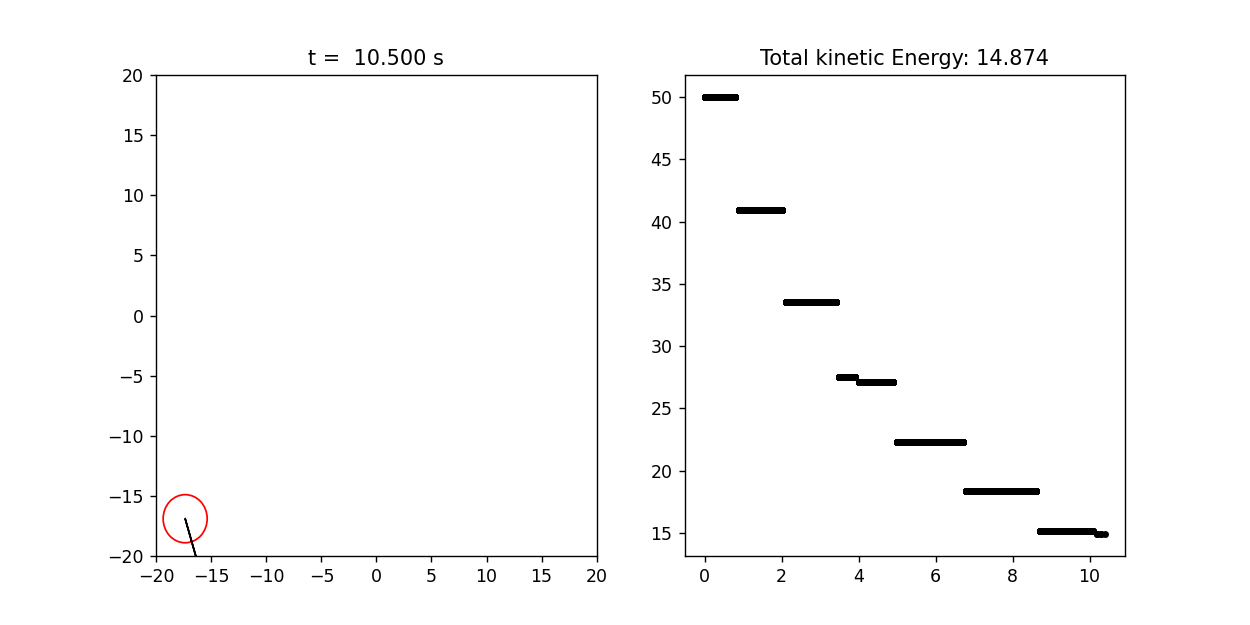

In [8]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

def init():
    
    ax.clear()
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
    
def Update(i):
    
    init()
    ax.set_title(r't =  %.3f s' %(t1[i]))
    
    
    # Queremos calcular la energía total de cinética
    KE = 0. # Kinetic energy
    
    for p in Particles:
        
        x = p.GetPosition(scale)[i,0]
        y = p.GetPosition(scale)[i,1]
        
        vx = p.GetVelocity(scale)[i,0]
        vy = p.GetVelocity(scale)[i,1]
        
        circle = plt.Circle( (x,y), p.radius, color='r', fill=False )
        ax.add_patch(circle)
        
        ax.arrow(x,y,vx,vy,color='k',head_width=0.5,length_includes_head=True)
        
        KE += p.GetKineticEnergy(scale)[i]
        
        ax1.set_title(r'Total kinetic Energy: {:.3f}'.format(KE))
        ax1.scatter(t1[:i], p.GetKineticEnergy(scale)[:i],color='k',marker='.')
        
Animation = anim.FuncAnimation(fig,Update,frames=len(t1),init_func=init)

In [9]:
MomentumT = Particles[0].GetMomentum(scale)

In [10]:
for i in range(1,len(Particles)):
    MomentumT = np.add(MomentumT,Particles[i].GetMomentum(scale))

<IPython.core.display.Javascript object>


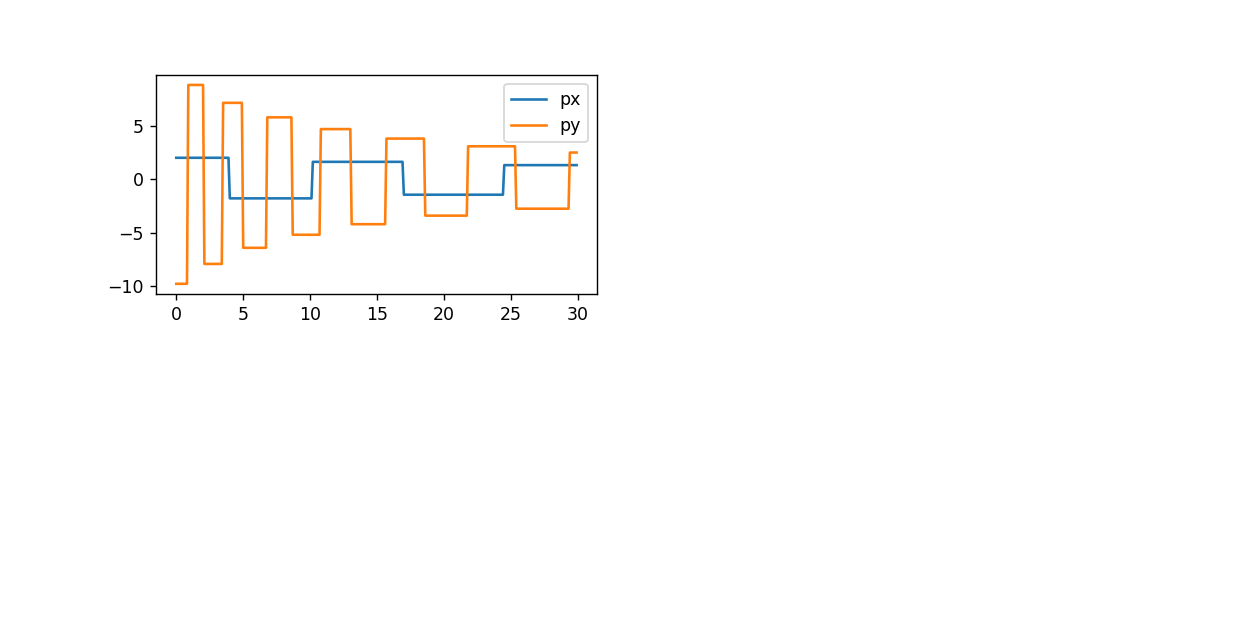

In [11]:
fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(221)
ax3.plot(t1,MomentumT[:,0],label='px')
ax3.plot(t1,MomentumT[:,1],label='py')
ax3.legend()

In [12]:
total_kinetic_energy = []
total_potential_energy = []
total_mechanical_energy = []

# Calcula las energías para cada punto de tiempo
for i in range(len(t1)):  # Asumiendo que t1 es tu arreglo de tiempo reducido
    kinetic_energy = sum(p.GetKineticEnergy(scale)[i] for p in Particles)
    potential_energy = sum(p.potential_energy for p in Particles)
    mechanical_energy = kinetic_energy + potential_energy
    
    total_kinetic_energy.append(kinetic_energy)
    total_potential_energy.append(potential_energy)
    total_mechanical_energy.append(mechanical_energy)

<IPython.core.display.Javascript object>


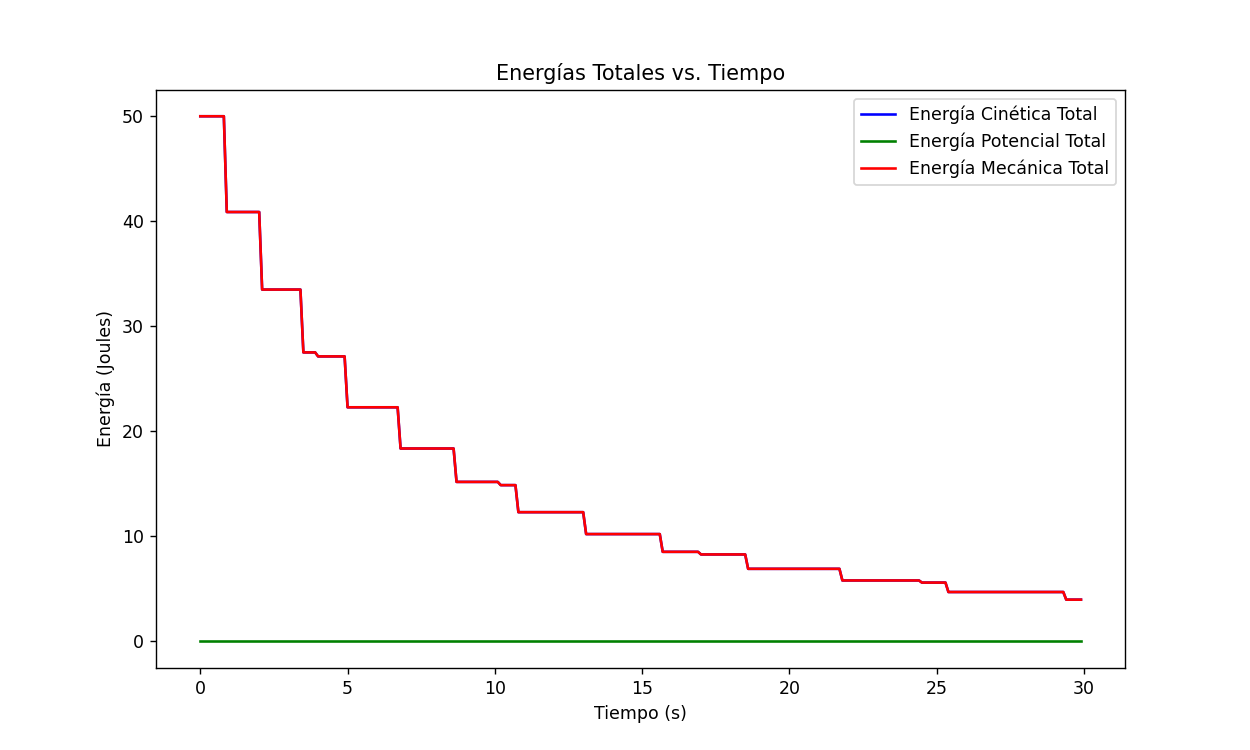

In [13]:
fig4, ax4 = plt.subplots(figsize=(10, 6))

# Graficar cada energía contra el tiempo
ax4.plot(t1, total_kinetic_energy, label='Energía Cinética Total', color='blue')
ax4.plot(t1, total_potential_energy, label='Energía Potencial Total', color='green')
ax4.plot(t1, total_mechanical_energy, label='Energía Mecánica Total', color='red')

ax4.set_title('Energías Totales vs. Tiempo')
ax4.set_xlabel('Tiempo (s)')
ax4.set_ylabel('Energía (Joules)')

ax4.legend()

plt.show()

In [14]:
# Inicializar una lista para almacenar el momento angular total en cada paso de tiempo
total_angular_momentum_z = []

for i in range(len(t)):  # Asumiendo que 't' es tu array de tiempo
    L_z_total = 0  # Momento angular total en el eje z para el paso de tiempo actual
    
    for p in Particles:
        # Obtener posición y momento lineal (m*v) de la partícula
        r = p.GetPosition()[i]  
        p = p.GetMomentum()[i]  
        
        # Calcular el momento angular de esta partícula en z
        L_z = r[0]*p[1] - r[1]*p[0]
        
        # Sumar al total
        L_z_total += L_z
    
    # Añadir el momento angular total de este paso de tiempo a la lista
    total_angular_momentum_z.append(L_z_total)

<IPython.core.display.Javascript object>


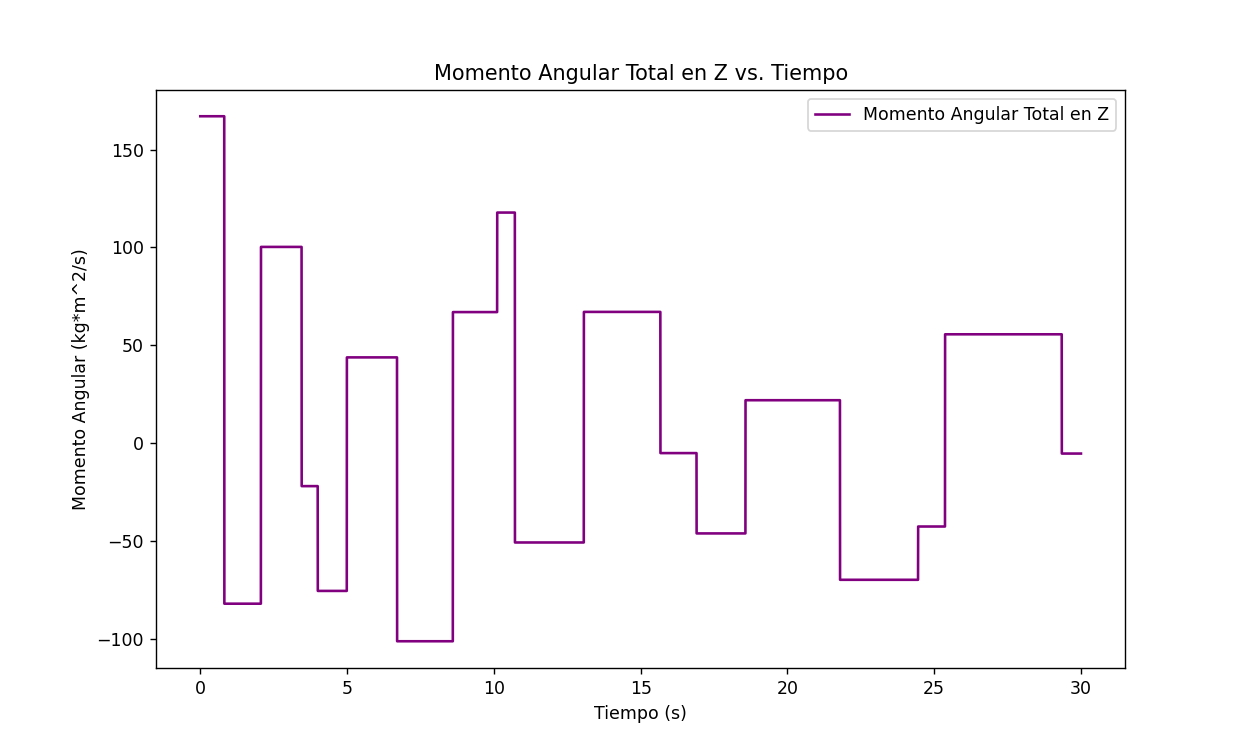

In [15]:
fig, ax5 = plt.subplots(figsize=(10, 6))

# Graficar el momento angular total en el eje z en función del tiempo
ax5.plot(t, total_angular_momentum_z, label='Momento Angular Total en Z', color='purple')

ax5.set_title('Momento Angular Total en Z vs. Tiempo')
ax5.set_xlabel('Tiempo (s)')
ax5.set_ylabel('Momento Angular (kg*m^2/s)')

ax5.legend()

plt.show()

# PUNTO 4

In [16]:
import numpy as np
import matplotlib.pyplot as plt

In [17]:
# Parámetros físicos
g = 9.81  # Aceleración debida a la gravedad en m/s^2
L = 1.0   # Longitud de la barra en metros
theta_0 = np.radians(10)  # Ángulo inicial en radianes

In [18]:
# Función que devuelve las derivadas de theta y omega
def derivatives(state, t):
    theta, omega = state
    dtheta_dt = omega
    domega_dt = -(3 * g / (2 * L)) * np.sin(theta)
    return np.array([dtheta_dt, domega_dt])

In [19]:
# Método de Euler para integración numérica
def euler_method(derivatives, y0, t):
    y = np.zeros((len(t), len(y0)))
    y[0] = y0
    for i in range(0, len(t) - 1):
        dt = t[i+1] - t[i]
        y[i+1] = y[i] + derivatives(y[i], t[i]) * dt
    return y

In [20]:
# Condiciones iniciales y generación del arreglo de tiempo
y0 = [theta_0, 0]  # Ángulo inicial y velocidad angular inicial
t = np.linspace(0, 10, 100)  # 100 puntos de tiempo entre 0 y 10 segundos

# Integración numérica
results = euler_method(derivatives, y0, t)

# Extracción de resultados
theta = results[:, 0]
omega = results[:, 1]

<IPython.core.display.Javascript object>


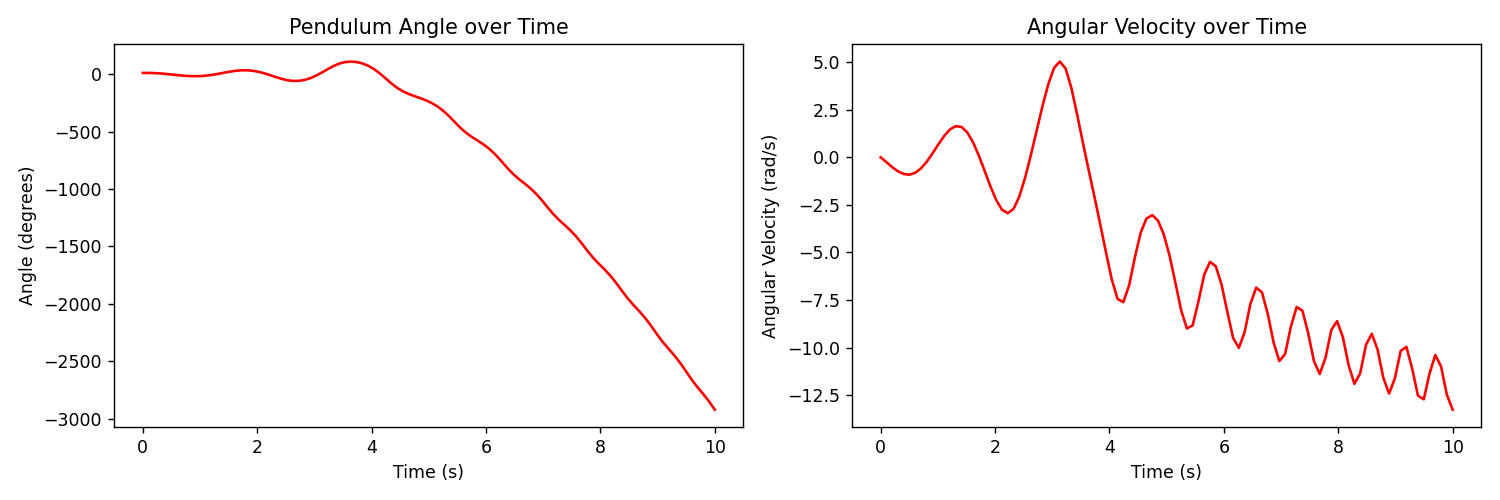

In [21]:
# Visualización
plt.figure(figsize=(12, 4))

# Ángulo a lo largo del tiempo
plt.subplot(1, 2, 1)
plt.plot(t, np.degrees(theta), color='red')  # Convertir radianes a grados para la visualización
plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
plt.title('Pendulum Angle over Time')

# Velocidad angular a lo largo del tiempo
plt.subplot(1, 2, 2)
plt.plot(t, omega, color='red')
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')
plt.title('Angular Velocity over Time')

plt.tight_layout()
plt.show()